In [3]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


df = pd.read_csv('Atmosphere Data/train/FDL_data.csv')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'Atmosphere Data/train/FDL_data.csv'

Data Cleaning and Preprocessing

Keep all relevant data for planets, remove star data

In [ ]:
# size of dataset

dataset_size = len(df)
dataset_size # dataset size


# Load and preprocess the data
df = pd.read_csv('Atmosphere Data/train/FDL_data.csv')
df.dropna(inplace=True)
df = df.drop(['Distance', 'Stellar Type', 'Stellar Temperature', 'Stellar Radius'], axis=1)

X = df.drop(['H20 abundance', 'CO2 abundance', 'O2 abundance', 'N2 abundance', 'CH4 abundance', 'N2O abundance', 'CO abundance', 'O3 abundance', 'SO2 abundance', 'NH3 abundance', 'C2H6 abundance', 'NO2 abundance'], axis=1)
Y = df[['H20 abundance', 'CO2 abundance', 'O2 abundance', 'N2 abundance', 'CH4 abundance', 'N2O abundance', 'CO abundance', 'O3 abundance', 'SO2 abundance', 'NH3 abundance', 'C2H6 abundance', 'NO2 abundance']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# save cleaned data for planet model to new csv file

df.to_csv('Atmosphere DataData/train/planet_cleaned_data.csv', index=False)
df = pd.read_csv('Atmosphere Data/train/planet_cleaned_data.csv')
df.head()

,Semi-Major Axis,Planet Radius,Planet Density,Planet Surface Pressure,kappa,gamma1,gamma2,alpha,beta,Planet Surface Temperature,...,CH4 abundance,N2O abundance,CO abundance,O3 abundance,SO2 abundance,NH3 abundance,C2H6 abundance,NO2 abundance,Avg Mol Weight,Mean Surface Albedo
0,0.236862,5547.156365,5.2366,3.132822,-2.729805,0.674501,-0.504562,0.530268,0.946155,305.640884,...,0.041486,0.009598,0.000569,0.003302,0.008869,0.000875,0.000164,0.000009,34.758161,0.139459
1,1.715127,4784.145073,4.9958,4.638380,-2.745324,0.735622,-0.286948,0.641666,0.756138,237.464144,...,0.047715,0.008109,0.004633,0.001051,0.016844,0.002147,0.000029,0.000010,38.791947,0.464953
2,0.832709,7876.184048,6.2445,0.778681,-2.585833,1.015678,-0.353109,0.624557,0.914404,214.440265,...,0.041270,0.007964,0.006792,0.001023,0.002749,0.000793,0.000400,0.000004,35.727996,0.499533
3,1.608417,10057.424776,7.5001,0.164969,-2.030302,-1.412910,-0.808585,0.337483,0.933829,224.203092,...,0.040105,0.006897,0.003239,0.001053,0.008461,0.003436,0.000364,0.000007,35.922788,0.414769
4,1.843825,6400.055371,5.3981,0.524024,-2.788137,0.897797,-1.359141,0.131381,0.840673,164.872988,...,0.038379,0.008838,0.004793,0.000932,0.004104,0.004237,0.000153,0.000004,33.018753,0.766516


Splitting Data 

In [ ]:
# Convert CSV to a numpy array
data = np.array(df)
m, n = data.shape

# Extract the column headers as a numpy array and reshape it
title_row = np.array(df.columns).reshape(1, n)

# Shuffle the array
np.random.seed(42)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

data_shuffled = data[indices]

# Split the array
train_idx = int(0.7 * data.shape[0])
test_idx = int(0.9 * data.shape[0])

train = np.vstack([title_row, data_shuffled[:train_idx]])
test = np.vstack([title_row, data_shuffled[train_idx:test_idx]])
validate = np.vstack([title_row, data_shuffled[test_idx:]])

# Ensure directories exist, if not, create them
os.makedirs('Atmosphere DataDataData/train/', exist_ok=True)
os.makedirs('Atmosphere DataData/test/', exist_ok=True)
os.makedirs('Atmosphere Data/validate/', exist_ok=True)

# Save numpy arrays to CSV. Add fmt='%s' to handle both strings (headers) and numbers.
np.savetxt('Atmosphere DataData/train/train_data.csv', train, delimiter=',', fmt='%s')
np.savetxt('Atmosphere Data/test/test_data.csv', test, delimiter=',', fmt='%s')
np.savetxt('Atmosphere Data/validate/validation_data.csv', validate, delimiter=',', fmt='%s')


Model Architecture

In [ ]:
# initialize weights

def initialize_weights(input_dim, hidden_layers, output_dim):
    np.random.seed(42) # for reproducibility
    layers = [input_dim] + hidden_layers + [output_dim]
    weights = []
    biases = []
    for i in range(len(layers)-1):
        weights.append(np.random.randn(layers[i], layers[i+1]) * 0.01)
        biases.append(np.zeros(layers[i+1]))
    return weights, biases


# activation functions

def relu(Z):
    return np.maximum(0, Z)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

# forward pass

def forward_pass(X, weights, biases):
    A = X
    cache = {"A0": X}
    for i in range(len(weights)):
        Z = np.dot(A, weights[i]) + biases[i]
        if i == len(weights) - 1:
            A = Z
        else:
            A = relu(Z)
        cache["Z" + str(i + 1)] = Z
        cache["A" + str(i + 1)] = A
    return A, cache


def update_parameters(weights, biases, grads, learning_rate):
    for i in range(len(weights)):
        weights[i] = weights[i] - learning_rate * grads["dW" + str(i + 1)]
        biases[i] = biases[i] - learning_rate * grads["db" + str(i + 1)]
    return weights, biases


def compute_cost_with_regularization(Y_hat, Y, weights, lambd):
    m = Y.shape[0]
    L2_regularization_cost = 0
    for w in weights:
        L2_regularization_cost += np.sum(np.square(w))
    cost = MSE(Y_hat, Y) + (lambd / (2 * m)) * L2_regularization_cost
    return cost

def backward_pass_with_regularization(Y, cache, weights, lambd):
    grads = {}
    m = Y.shape[0]
    dA = cache["A" + str(len(weights))] - Y
    for i in range(len(weights), 0, -1):
        dZ = relu_backward(dA, cache["Z" + str(i)])
        grads["dW" + str(i)] = (1/m) * np.dot(cache["A" + str(i - 1)].T, dZ) + (lambd/m) * weights[i-1]
        grads["db" + str(i)] = (1/m) * np.sum(dZ, axis=0, keepdims=True)
        dA = np.dot(dZ, weights[i-1].T)
    return grads

def get_learning_rate(base_lr, iteration, decay_rate, decay_step):
    return base_lr * (1 / (1 + decay_rate * (iteration/decay_step)))

def train(X, Y, base_learning_rate, decay_rate, num_iterations, hidden_layers, lambd):
    input_dim = X.shape[1]
    output_dim = 1 if len(Y.shape) == 1 else Y.shape[1]
    weights, biases = initialize_weights(input_dim, hidden_layers, output_dim)
    
    for i in range(num_iterations):
        learning_rate = get_learning_rate(base_learning_rate, i, decay_rate, 100)
        Y_hat, cache = forward_pass(X, weights, biases)
        cost = compute_cost_with_regularization(Y_hat, Y, weights, lambd)
        grads = backward_pass_with_regularization(Y, cache, weights, lambd)
        weights, biases = update_parameters(weights, biases, grads, learning_rate)
        if i % 100 == 0:
            print(f"Iteration {i}, Cost: {cost}")
    return weights, biases

# Mean Squared Error function
def MSE(Y_pred, Y_true):
    return np.mean(np.square(Y_pred - Y_true))

# Call the train function
lambd = 0.7  # Regularization parameter
base_learning_rate = 0.01
decay_rate = 0.01
weights, biases = train(X_train, Y_train.values, base_learning_rate, decay_rate, num_iterations=1000, hidden_layers=[128, 64, 32], lambd=lambd)


def predict(X, weights, biases):
    Y_hat, _ = forward_pass(X, weights, biases)
    return Y_hat


# Prediction and error calculation
Y_pred = predict(X_test, weights, biases)
print(f"Test MSE: {MSE(Y_pred, Y_test.values)}")




Iteration 0, Cost: 0.08819708198506984
Iteration 100, Cost: 0.05659808325826518
Iteration 200, Cost: 0.04488291114374779
Iteration 300, Cost: 0.037240055342041514
Iteration 400, Cost: 0.03126608603298701
Iteration 500, Cost: 0.026420938084608863
Iteration 600, Cost: 0.02245963650735333
Iteration 700, Cost: 0.019211413278671326
Iteration 800, Cost: 0.016542480881428977
Iteration 900, Cost: 0.014345466699545608
Test MSE: 0.010082679710303508


Visualization

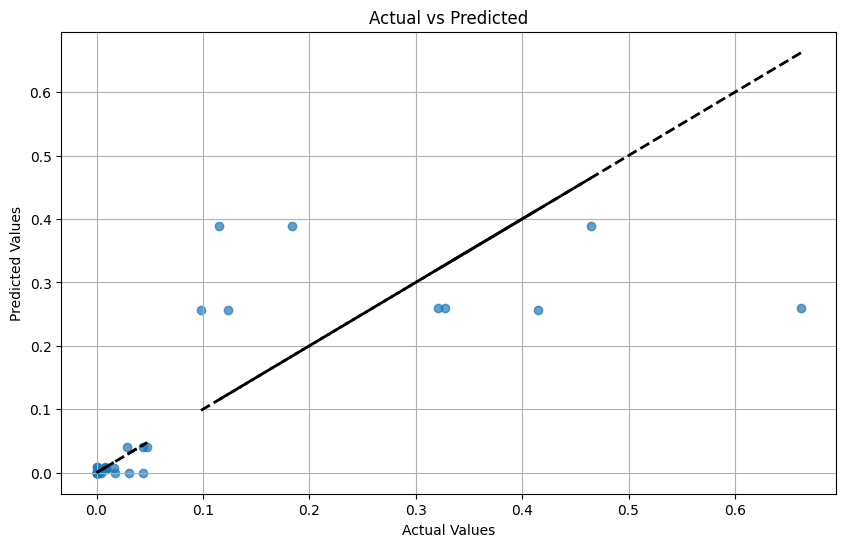

In [ ]:
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(Y_true, Y_pred):
    plt.figure(figsize=(10, 6))
    
    plt.scatter(Y_true, Y_pred, alpha=0.7)
    plt.plot([Y_true.min(), Y_true.max()], [Y_true.min(), Y_true.max()], 'k--', lw=2)
    
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted')
    plt.grid(True)
    plt.show()

plot_actual_vs_predicted(Y_test, Y_pred)


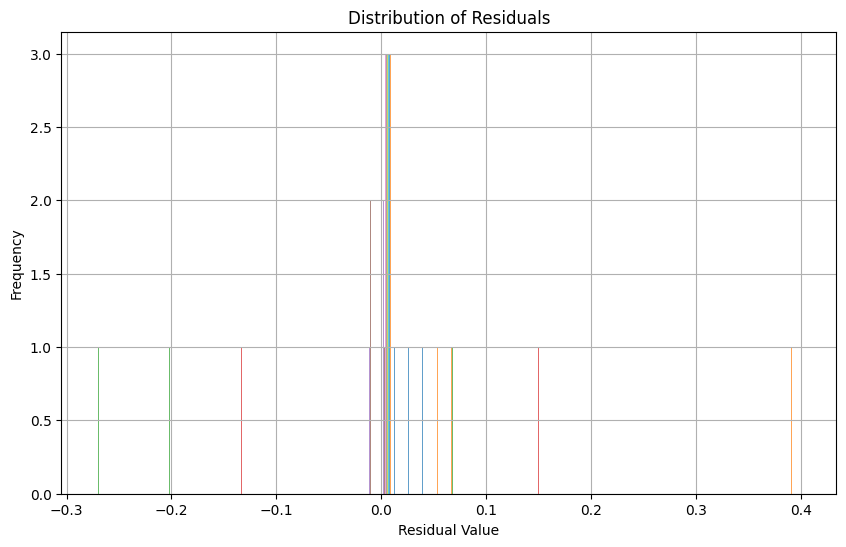

In [ ]:
def plot_residuals(Y_true, Y_pred):
    residuals = Y_true - Y_pred
    plt.figure(figsize=(10, 6))
    
    plt.hist(residuals, bins=50, alpha=0.7)
    
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals')
    plt.grid(True)
    plt.show()

plot_residuals(Y_test, Y_pred)
